In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torch.autograd.variable import Variable
import os
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
lr = 0.0002
latent_size = 100
epochs = 50

class NikeDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = NikeDataset(root_dir='augmented_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()


# Training loop
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        real_images = data.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(noise)

        output_real = discriminator(real_images)
        output_fake = discriminator(fake_images.detach())

        # Binary Cross-Entropy Loss without manual label creation
        loss_real = criterion(output_real, torch.ones_like(output_real))
        loss_fake = criterion(output_fake, torch.zeros_like(output_fake))

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        output_fake = discriminator(fake_images)
        
        # Binary Cross-Entropy Loss without manual label creation
        loss_G = criterion(output_fake, torch.ones_like(output_fake))

        loss_G.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader), loss_D.item(), loss_G.item()))

    # Save generated images at the end of each epoch
    if epoch % 5 == 0:
        with torch.no_grad():
            fake = generator(torch.randn(64, latent_size, 1, 1, device=device))
        utils.save_image(fake, 'fake_samples_epoch_%03d.png' % epoch, normalize=True)

# Save models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


[0/50][0/47] Loss_D: 1.3835 Loss_G: 1.8286
[1/50][0/47] Loss_D: 0.0320 Loss_G: 6.0068
[2/50][0/47] Loss_D: 0.0220 Loss_G: 6.5668
[3/50][0/47] Loss_D: 0.0141 Loss_G: 5.8555
[4/50][0/47] Loss_D: 0.0052 Loss_G: 6.5814
[5/50][0/47] Loss_D: 0.0042 Loss_G: 6.7607
[6/50][0/47] Loss_D: 0.0043 Loss_G: 6.4646
[7/50][0/47] Loss_D: 0.0016 Loss_G: 7.2467
[8/50][0/47] Loss_D: 0.0015 Loss_G: 7.3016
[9/50][0/47] Loss_D: 0.0010 Loss_G: 7.5703
[10/50][0/47] Loss_D: 0.0009 Loss_G: 7.9684
[11/50][0/47] Loss_D: 0.0007 Loss_G: 8.0368
[12/50][0/47] Loss_D: 0.0007 Loss_G: 8.2007
[13/50][0/47] Loss_D: 0.0005 Loss_G: 8.4188
[14/50][0/47] Loss_D: 0.0004 Loss_G: 8.6490
[15/50][0/47] Loss_D: 0.0004 Loss_G: 8.7449
[16/50][0/47] Loss_D: 0.0004 Loss_G: 8.9262
[17/50][0/47] Loss_D: 0.0004 Loss_G: 9.0464
[18/50][0/47] Loss_D: 0.0005 Loss_G: 9.0817
[19/50][0/47] Loss_D: 0.0005 Loss_G: 8.9906
[20/50][0/47] Loss_D: 0.0003 Loss_G: 9.2489
[21/50][0/47] Loss_D: 0.0006 Loss_G: 9.2106
[22/50][0/47] Loss_D: 0.0004 Loss_G: 9.386

In [ ]:
# Print accuracy for the final epoch
final_train_accuracy = train_correct[-1] * 100 / len(train_loader.dataset)
final_test_accuracy = test_correct[-1] * 100 / len(test_loader.dataset)
print(f'\nFinal Training Accuracy: {final_train_accuracy:.2f}%')
print(f'Final Testing Accuracy: {final_test_accuracy:.2f}%')



Final Training Accuracy: 99.92%
Final Testing Accuracy: 77.91%


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torch.autograd.variable import Variable
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
batch_size = 512
lr = 0.0001
latent_size = 100
epochs = 5
lambda_gp = 10  # Gradient penalty coefficient

class NikeDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = NikeDataset(root_dir='augmented_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

def gradient_penalty(discriminator, real_samples, fake_samples):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).expand_as(real_samples).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Ensure both real and fake samples have the same size using F.interpolate
    interpolates_resized = F.interpolate(interpolates, size=(real_samples.size(2), real_samples.size(3)), mode='nearest')

    d_interpolates = discriminator(interpolates_resized)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates_resized,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

# Training loop
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        real_images = data.to(device)
        batch_size = real_images.size(0)  # Fix batch size inconsistency

        # Train Discriminator
        optimizer_D.zero_grad()

        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(noise)

        # Resize fake images to match the size of real images
        fake_images_resized = nn.functional.interpolate(fake_images, size=(real_images.size(2), real_images.size(3)))

        output_real = discriminator(real_images)
        output_fake = discriminator(fake_images_resized.detach())

        loss_real = criterion(output_real, torch.ones_like(output_real))
        loss_fake = criterion(output_fake, torch.zeros_like(output_fake))
        loss_D = loss_real + loss_fake

        # Gradient Penalty
        gp = gradient_penalty(discriminator, real_images.data, fake_images_resized.data)
        loss_D += lambda_gp * gp

        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        output_fake = discriminator(fake_images_resized)
        loss_G = criterion(output_fake, torch.ones_like(output_fake))

        loss_G.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader), loss_D.item(), loss_G.item()))

    # Save generated images at the end of each epoch
    if epoch % 5 == 0:
        with torch.no_grad():
            fake = generator(torch.randn(64, latent_size, 1, 1, device=device))
        utils.save_image(fake, 'fake_samples_epoch_%03d.png' % epoch, normalize=True)


# Save models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


[0/5][0/6] Loss_D: 2.6333 Loss_G: 0.6610
[1/5][0/6] Loss_D: 1.3262 Loss_G: 0.8080
[2/5][0/6] Loss_D: 1.1921 Loss_G: 0.9128
[3/5][0/6] Loss_D: 1.0327 Loss_G: 1.0456
[4/5][0/6] Loss_D: 0.9338 Loss_G: 1.1276


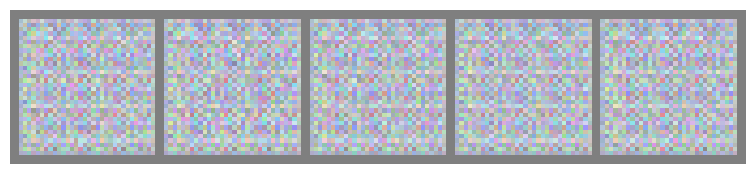

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Load the trained generator model
generator = Generator().to(device)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Generate 5 images
num_images = 5
with torch.no_grad():
    noise = torch.randn(num_images, latent_size, 1, 1, device=device)
    generated_images = generator(noise)

# Denormalize the images (if normalization was applied during training)
# Replace 'mean' and 'std' with the values used during training if applicable
denormalize = transforms.Compose([transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]), transforms.ToPILImage()])
generated_images_denorm = make_grid(generated_images.cpu(), nrow=5, normalize=True)
generated_images_denorm = denormalize(generated_images_denorm)

# Plot the generated images
plt.figure(figsize=(10, 2))
plt.imshow(generated_images_denorm)
plt.axis('off')
plt.show()